In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 08:56:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

def readFile(filename):

    # Read the file into an RDD
    lines = sc.textFile(filename)

    # Process each line in the RDD, each element in data ends in a tuple containing a list of the first 11 features, and a number representing the target
    data = lines.map(lambda line: line.split(','))\
                .map(lambda elem: ([float(x) for x in elem[:-1]], int(elem[-1])))

    return data

In [3]:
# Function that computes the means and std devs
def compute_mean_stds(RDD):

    # Calculate sum and sum of squares for each feature
    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: a+b)
    sum_of_squares = RDD.map(lambda x: x[0]**2).reduce(lambda a, b: a+b)
    count = RDD.count()

    # Compute mean and standard deviation for each feature
    means = sums / count
    stds = ((sum_of_squares / count) - means ** 2) ** 0.5 
    
    return means, stds


def normalize(RDD_Xy):
    # Compute means and standard deviations
    means, stds = compute_mean_stds(RDD_Xy)

    normalized_RDD = RDD_Xy.map(lambda x: ((x[0] - means) / stds , x[1]))
    return normalized_RDD



In [4]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Function that computes the value z, which is indeed a linear combination of weights and features + the bias
def linear_combination(features, weights, bias):
    return sum(weights[j] * features[j] for j in range(len(weights))) + bias


# Function to compute the gradient of each record (row) of the dataset
def compute_gradients_and_cost(record, weights, bias):
    xi, yi = record

    y_hat = sigmoid(linear_combination(xi, weights, bias))
    error = y_hat - yi
    dw = np.zeros(len(weights))

    for j in range(len(weights)):
        dw[j] = error * xi[j]
    
    db = error
    cost_contribution = -yi * np.log(y_hat) - (1 - yi) * np.log(1 - y_hat)
    
    return (dw, db, cost_contribution)


# Actual train function
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    np.random.seed(0) 
    feature_count = len(RDD_Xy.first()[0])
    w = np.random.rand(feature_count)
    b = np.random.rand()
    m = RDD_Xy.count()

    for n in range(iterations):
        
        gradients_and_cost = RDD_Xy.map(lambda x: compute_gradients_and_cost(x, w, b))
        dw, db, total_cost = gradients_and_cost.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2]))
        
        reg_cost = (lambda_reg / (2 * feature_count)) * np.sum(np.square(w))
        cost = (total_cost / m) + reg_cost
        
        # Update weights and bias
        w -= learning_rate * ((dw / m) + (lambda_reg/m) * w)
        b -= learning_rate * db / m


        print(f"Iteration {n+1}/{iterations} - Cost: {cost}")

    return w, b


In [5]:
# Predict function
def predict(w, b, x):
    z = 0
    for j in range(len(w)):
        z += w[j] * x[j]

    z+= b
    # Compute the sigmoid of z
    y_hat = sigmoid(z)

    if y_hat > 0.5:
        return 1
    else: 
        return 0




In [6]:
# Accuracy function
def accuracy(w, b, RDD_Xy):
    
    results = RDD_Xy.map(lambda r: 1 if predict(w, b, r[0]) == r[1] else 0)
    results = results.reduce( lambda a, b: a + b)

    accuracy = results / RDD_Xy.count()
    return accuracy

In [7]:
import numpy as np

def get_uniform_number(min=1, max=10):
    # Generate a float number from uniform distribution
    float_number = np.random.uniform(min, max + 0.9999)

    # Round the float number to the nearest integer, ensuring it's between 1 and 10, inclusive
    int_number = int(np.clip(float_number, 1, 10))

    return int_number


def assign_uniform_blocks(RDD):

    def assign_block(record):
        block_num = get_uniform_number(0, 10)
        return record + (block_num,)

    RDD_with_blocks = RDD.map(assign_block)

    return RDD_with_blocks


In [8]:
def cross_validate(RDD_Xy_with_blocks, num_blocks=10, iterations=10, learning_rate=1.5, lambda_reg=0):
    total_accuracy = 0

    for test_block in range(1, num_blocks + 1):
        
        training_RDD = RDD_Xy_with_blocks.flatMap(lambda x: [(x[0], x[1])] if x[-1] != test_block else [])
        test_RDD = RDD_Xy_with_blocks.flatMap(lambda x: [(x[0], x[1])] if x[-1] == test_block else [])

        w, b = train(training_RDD, iterations, learning_rate, lambda_reg)

        current_accuracy = accuracy(w, b, test_RDD)
        print(f"Accuracy for block {test_block} as test set: {current_accuracy}")

        total_accuracy += current_accuracy

    average_accuracy = total_accuracy / num_blocks
    return average_accuracy

In [9]:
import os
import sys
import time
import pyspark
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
sc.stop()
times = []
for i in [3, 9, 12]:
    print("Number of cores: ", i)
    start_time = time.time()
    number_cores = i
    conf = (
        pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
    )
    sc = pyspark.SparkContext(conf=conf)

    filename = 'data/botnet_tot_syn_l.csv'
    RDD_Xy = readFile(filename).map( lambda x: (np.array(x[0]), x[1]))
    normalized_RDD = normalize(RDD_Xy)
    RDD_Xy_with_blocks = assign_uniform_blocks(normalized_RDD)
    average_accuracy = cross_validate(RDD_Xy_with_blocks)
    print("Average Cross-Validation Accuracy:", average_accuracy)
    times.append(time.time() - start_time)
    sc.stop()

Number of cores:  3


Iteration 1/10 - Cost: 1.5011952122128598


Iteration 2/10 - Cost: 0.7451456687034745


Iteration 3/10 - Cost: 0.4458109140018467


Iteration 4/10 - Cost: 0.33601964369858367


Iteration 5/10 - Cost: 0.285845904560622


Iteration 6/10 - Cost: 0.2583696009514417


Iteration 7/10 - Cost: 0.2411044895069886


Iteration 8/10 - Cost: 0.2285396752306502


Iteration 9/10 - Cost: 0.22006555719327958


Iteration 10/10 - Cost: 0.21350347251424476


Accuracy for block 1 as test set: 0.9316684086033336


Iteration 1/10 - Cost: 1.4979371540174888


Iteration 2/10 - Cost: 0.7454945110747555


Iteration 3/10 - Cost: 0.4460495158527277


Iteration 4/10 - Cost: 0.33553569153363166


Iteration 5/10 - Cost: 0.28570196579553536


Iteration 6/10 - Cost: 0.2581567328752888


Iteration 7/10 - Cost: 0.2406025934203161


Iteration 8/10 - Cost: 0.22875431619585343


Iteration 9/10 - Cost: 0.2197144052213201


Iteration 10/10 - Cost: 0.21296416688921843


Accuracy for block 2 as test set: 0.9310776667032846


Iteration 1/10 - Cost: 1.499064109761326


Iteration 2/10 - Cost: 0.7445763936781506


Iteration 3/10 - Cost: 0.4465816188368245


Iteration 4/10 - Cost: 0.3361419530096336


Iteration 5/10 - Cost: 0.2857846992648173


Iteration 6/10 - Cost: 0.2580135753208985


Iteration 7/10 - Cost: 0.2407412931627873


Iteration 8/10 - Cost: 0.22852784383120545


Iteration 9/10 - Cost: 0.21989413506615405


Iteration 10/10 - Cost: 0.21320862731886808


Accuracy for block 3 as test set: 0.9358616350812905


Iteration 1/10 - Cost: 1.4998828627540304


Iteration 2/10 - Cost: 0.745263052966727


Iteration 3/10 - Cost: 0.44638542933444053


Iteration 4/10 - Cost: 0.33599719882090096


Iteration 5/10 - Cost: 0.28544176821893014


Iteration 6/10 - Cost: 0.25807987304269603


Iteration 7/10 - Cost: 0.2406689530699089


Iteration 8/10 - Cost: 0.22848552121029483


Iteration 9/10 - Cost: 0.2199394316471155


Iteration 10/10 - Cost: 0.2131854735129982


Accuracy for block 4 as test set: 0.9262630709961475


Iteration 1/10 - Cost: 1.5012023872782518


Iteration 2/10 - Cost: 0.7451451264752318


Iteration 3/10 - Cost: 0.44584416939937455


Iteration 4/10 - Cost: 0.33588133608904686


Iteration 5/10 - Cost: 0.28582665033504073


Iteration 6/10 - Cost: 0.2581702307095913


Iteration 7/10 - Cost: 0.24080893364890704


Iteration 8/10 - Cost: 0.22892000858571035


Iteration 9/10 - Cost: 0.21994612171790998


Iteration 10/10 - Cost: 0.21307074447725322


Accuracy for block 5 as test set: 0.9235046390735013


Iteration 1/10 - Cost: 1.4984392569926737


Iteration 2/10 - Cost: 0.7455574409418172


Iteration 3/10 - Cost: 0.44643611774081704


Iteration 4/10 - Cost: 0.3354632665890678


Iteration 5/10 - Cost: 0.2859839495772769


Iteration 6/10 - Cost: 0.25817547860916573


Iteration 7/10 - Cost: 0.24074816291102338


Iteration 8/10 - Cost: 0.22872159812759763


Iteration 9/10 - Cost: 0.21974990114185544


Iteration 10/10 - Cost: 0.21295602252767862


Accuracy for block 6 as test set: 0.9331474182321231


Iteration 1/10 - Cost: 1.5000746761096322


Iteration 2/10 - Cost: 0.7450611284307965


Iteration 3/10 - Cost: 0.44681841444878084


Iteration 4/10 - Cost: 0.3358684248506972


Iteration 5/10 - Cost: 0.285883326660243


Iteration 6/10 - Cost: 0.2583216212027774


Iteration 7/10 - Cost: 0.24097051190251895


Iteration 8/10 - Cost: 0.2288070291413841


Iteration 9/10 - Cost: 0.21988125134355122


Iteration 10/10 - Cost: 0.2132221320524561


Accuracy for block 7 as test set: 0.9370424921649187


Iteration 1/10 - Cost: 1.5009857381244356


Iteration 2/10 - Cost: 0.7443126257892692


Iteration 3/10 - Cost: 0.4461298845059512


Iteration 4/10 - Cost: 0.33606755504980523


Iteration 5/10 - Cost: 0.28567701036767856


Iteration 6/10 - Cost: 0.2579562841592053


Iteration 7/10 - Cost: 0.24074632237126528


Iteration 8/10 - Cost: 0.2286518182112132


Iteration 9/10 - Cost: 0.21989684032497395


Iteration 10/10 - Cost: 0.21317354735612298


Accuracy for block 8 as test set: 0.9331745401614397


Iteration 1/10 - Cost: 1.4984968807303292


Iteration 2/10 - Cost: 0.745213779980755


Iteration 3/10 - Cost: 0.44640761043647154


Iteration 4/10 - Cost: 0.3358269878636802


Iteration 5/10 - Cost: 0.2858035590631458


Iteration 6/10 - Cost: 0.2583374304909956


Iteration 7/10 - Cost: 0.24068860839283632


Iteration 8/10 - Cost: 0.2287370521511939


Iteration 9/10 - Cost: 0.2199960807800411


Iteration 10/10 - Cost: 0.21298879267683055


Accuracy for block 9 as test set: 0.9337764403734444


Iteration 1/10 - Cost: 1.5001567712494417


Iteration 2/10 - Cost: 0.744878960446206


Iteration 3/10 - Cost: 0.44622579700529835


Iteration 4/10 - Cost: 0.3361200768642561


Iteration 5/10 - Cost: 0.28577854861057356


Iteration 6/10 - Cost: 0.2581035108081852


Iteration 7/10 - Cost: 0.2410425696651815


Iteration 8/10 - Cost: 0.22897039323130647


Iteration 9/10 - Cost: 0.22003345626492932


Iteration 10/10 - Cost: 0.21331265910109581


Accuracy for block 10 as test set: 0.9246351724440159
Average Cross-Validation Accuracy: 0.9310151483833501
Number of cores:  9


Iteration 1/10 - Cost: 1.5009536502485754


Iteration 2/10 - Cost: 0.7447211873777915


Iteration 3/10 - Cost: 0.44665660641408433


Iteration 4/10 - Cost: 0.3360548569817764


Iteration 5/10 - Cost: 0.28653599196216917


Iteration 6/10 - Cost: 0.25860062972941966


Iteration 7/10 - Cost: 0.24068408830304552


Iteration 8/10 - Cost: 0.22835660664844346


Iteration 9/10 - Cost: 0.2199096288157047


Iteration 10/10 - Cost: 0.21391058886689593


Accuracy for block 1 as test set: 0.9331891677194066


Iteration 1/10 - Cost: 1.498393912042445


Iteration 2/10 - Cost: 0.7456873727279338


Iteration 3/10 - Cost: 0.44660110014246907


Iteration 4/10 - Cost: 0.33563431533295957


Iteration 5/10 - Cost: 0.2856305675717671


Iteration 6/10 - Cost: 0.25802796514378157


Iteration 7/10 - Cost: 0.2407208858237869


Iteration 8/10 - Cost: 0.2285172732488617


Iteration 9/10 - Cost: 0.21964926380763275


Iteration 10/10 - Cost: 0.2129671290335655


Accuracy for block 2 as test set: 0.9375585974123383


Iteration 1/10 - Cost: 1.498309209508165


Iteration 2/10 - Cost: 0.7451633495472445


Iteration 3/10 - Cost: 0.4464323122609798


Iteration 4/10 - Cost: 0.3362167910298178


Iteration 5/10 - Cost: 0.2860792692300973


Iteration 6/10 - Cost: 0.25823898745341195


Iteration 7/10 - Cost: 0.2408373602528536


Iteration 8/10 - Cost: 0.228931063105817


Iteration 9/10 - Cost: 0.22000961352929485


Iteration 10/10 - Cost: 0.21344256565233416


Accuracy for block 3 as test set: 0.9315206998494356


Iteration 1/10 - Cost: 1.5003438616983447


Iteration 2/10 - Cost: 0.7452830379887843


Iteration 3/10 - Cost: 0.44615207936064966


Iteration 4/10 - Cost: 0.3363250117272406


Iteration 5/10 - Cost: 0.2857619544326103


Iteration 6/10 - Cost: 0.2583012884877005


Iteration 7/10 - Cost: 0.24087511372271078


Iteration 8/10 - Cost: 0.22874281330226223


Iteration 9/10 - Cost: 0.21983416986442886


Iteration 10/10 - Cost: 0.21306570682433523


Accuracy for block 4 as test set: 0.9244906681863513


Iteration 1/10 - Cost: 1.5011460719537044


Iteration 2/10 - Cost: 0.7452669611826993


Iteration 3/10 - Cost: 0.4456897969505089


Iteration 4/10 - Cost: 0.33587653467139705


Iteration 5/10 - Cost: 0.28588913717829056


Iteration 6/10 - Cost: 0.258187078245826


Iteration 7/10 - Cost: 0.24077630964367128


Iteration 8/10 - Cost: 0.22874951118727455


Iteration 9/10 - Cost: 0.21983893268281796


Iteration 10/10 - Cost: 0.2131812791291098


Accuracy for block 5 as test set: 0.9228029152416438


Iteration 1/10 - Cost: 1.4998208416928032


Iteration 2/10 - Cost: 0.745148032643948


Iteration 3/10 - Cost: 0.44573050940808334


Iteration 4/10 - Cost: 0.3359303443225958


Iteration 5/10 - Cost: 0.2861569604731609


Iteration 6/10 - Cost: 0.258012967907657


Iteration 7/10 - Cost: 0.24089895068166203


Iteration 8/10 - Cost: 0.2289020169736637


Iteration 9/10 - Cost: 0.2198908164670495


Iteration 10/10 - Cost: 0.21293994220811813


Accuracy for block 6 as test set: 0.9243613965730012


Iteration 1/10 - Cost: 1.4992811986622716


Iteration 2/10 - Cost: 0.7447465425262008


Iteration 3/10 - Cost: 0.44648897555451983


Iteration 4/10 - Cost: 0.3358681204566743


Iteration 5/10 - Cost: 0.2860553906775406


Iteration 6/10 - Cost: 0.25831053617790084


Iteration 7/10 - Cost: 0.24071736280108424


Iteration 8/10 - Cost: 0.228709282317974


Iteration 9/10 - Cost: 0.21975764596935804


Iteration 10/10 - Cost: 0.21304386182025112


Accuracy for block 7 as test set: 0.9305347546471676


Iteration 1/10 - Cost: 1.4994369282438862


Iteration 2/10 - Cost: 0.7454254767059544


Iteration 3/10 - Cost: 0.4468029885124116


Iteration 4/10 - Cost: 0.33597846824625366


Iteration 5/10 - Cost: 0.28611156221369033


Iteration 6/10 - Cost: 0.2582795370373727


Iteration 7/10 - Cost: 0.24110394095523383


Iteration 8/10 - Cost: 0.22874933688376692


Iteration 9/10 - Cost: 0.21978473586670122


Iteration 10/10 - Cost: 0.2132008728837198


Accuracy for block 8 as test set: 0.9312944240872367


Iteration 1/10 - Cost: 1.4972501036105925


Iteration 2/10 - Cost: 0.7456433468953588


Iteration 3/10 - Cost: 0.4463503130683001


Iteration 4/10 - Cost: 0.336605290495218


Iteration 5/10 - Cost: 0.2860893246240583


Iteration 6/10 - Cost: 0.2581809399313304


Iteration 7/10 - Cost: 0.24056916132966183


Iteration 8/10 - Cost: 0.22878853554247344


Iteration 9/10 - Cost: 0.21986887317980736


Iteration 10/10 - Cost: 0.2130889743012508


Accuracy for block 9 as test set: 0.9308757279419844


Iteration 1/10 - Cost: 1.4995194000287135


Iteration 2/10 - Cost: 0.7458876888431955


Iteration 3/10 - Cost: 0.4461209142241293


Iteration 4/10 - Cost: 0.3360098437840606


Iteration 5/10 - Cost: 0.2857805083879714


Iteration 6/10 - Cost: 0.2581479033933818


Iteration 7/10 - Cost: 0.24090364625357516


Iteration 8/10 - Cost: 0.22900563339989835


Iteration 9/10 - Cost: 0.22002593155638697


Iteration 10/10 - Cost: 0.21335249692944347


Accuracy for block 10 as test set: 0.9351473175021988
Average Cross-Validation Accuracy: 0.9301775669160766
Number of cores:  12


Iteration 1/10 - Cost: 1.4973348456134097


Iteration 2/10 - Cost: 0.7442921361574212


Iteration 3/10 - Cost: 0.44644650774162054


Iteration 4/10 - Cost: 0.33614300256179896


Iteration 5/10 - Cost: 0.28612784164037436


Iteration 6/10 - Cost: 0.2582486390893974


Iteration 7/10 - Cost: 0.2405724275785095


Iteration 8/10 - Cost: 0.22863159422591936


Iteration 9/10 - Cost: 0.2195365490337055


Iteration 10/10 - Cost: 0.21261992268516378


Accuracy for block 1 as test set: 0.9376589978218337


Iteration 1/10 - Cost: 1.498217799945581


Iteration 2/10 - Cost: 0.745251288653784


Iteration 3/10 - Cost: 0.4464105347162772


Iteration 4/10 - Cost: 0.3357725167674129


Iteration 5/10 - Cost: 0.28606335696339547


Iteration 6/10 - Cost: 0.2577839903951798


Iteration 7/10 - Cost: 0.24059846952534966


Iteration 8/10 - Cost: 0.22871114650831922


Iteration 9/10 - Cost: 0.21994319102785742


Iteration 10/10 - Cost: 0.21308526927676755


Accuracy for block 2 as test set: 0.9351207030815442


Iteration 1/10 - Cost: 1.4994778202574661


Iteration 2/10 - Cost: 0.7443877228917029


Iteration 3/10 - Cost: 0.4464767484083697


Iteration 4/10 - Cost: 0.3358732200845235


Iteration 5/10 - Cost: 0.285882025540687


Iteration 6/10 - Cost: 0.25816813766670116


Iteration 7/10 - Cost: 0.24020612959346194


Iteration 8/10 - Cost: 0.22866613877689237


Iteration 9/10 - Cost: 0.21988979822724608


Iteration 10/10 - Cost: 0.21334730467018073


Accuracy for block 3 as test set: 0.9312279541446208


Iteration 1/10 - Cost: 1.4986109045469131


Iteration 2/10 - Cost: 0.7455131529947344


Iteration 3/10 - Cost: 0.44670207604992124


Iteration 4/10 - Cost: 0.33607217775813863


Iteration 5/10 - Cost: 0.28614696107404186


Iteration 6/10 - Cost: 0.2581880077254839


Iteration 7/10 - Cost: 0.24098032372225286


Iteration 8/10 - Cost: 0.22891966360278632


Iteration 9/10 - Cost: 0.22009424126596458


Iteration 10/10 - Cost: 0.2133800815726743


Accuracy for block 4 as test set: 0.9276279702481515


Iteration 1/10 - Cost: 1.4991394233911526


Iteration 2/10 - Cost: 0.7460791288263626


Iteration 3/10 - Cost: 0.4460224242674681


Iteration 4/10 - Cost: 0.33574486667427744


Iteration 5/10 - Cost: 0.28566766422464857


Iteration 6/10 - Cost: 0.2580966889568664


Iteration 7/10 - Cost: 0.2406629681436204


Iteration 8/10 - Cost: 0.22857221826185567


Iteration 9/10 - Cost: 0.21999439541585997


Iteration 10/10 - Cost: 0.21312178622457764


Accuracy for block 5 as test set: 0.9330770498105333


Iteration 1/10 - Cost: 1.50001647523498


Iteration 2/10 - Cost: 0.7455479245791596


Iteration 3/10 - Cost: 0.44610736743334267


Iteration 4/10 - Cost: 0.3354624627315216


Iteration 5/10 - Cost: 0.28545486093833045


Iteration 6/10 - Cost: 0.25832577193413164


Iteration 7/10 - Cost: 0.24084985788714297


Iteration 8/10 - Cost: 0.22868020673062


Iteration 9/10 - Cost: 0.21990409268544922


Iteration 10/10 - Cost: 0.21332564916799246


Accuracy for block 6 as test set: 0.9292969352457752


Iteration 1/10 - Cost: 1.5001115176856124


Iteration 2/10 - Cost: 0.7455599874293115


Iteration 3/10 - Cost: 0.44616709256195153


Iteration 4/10 - Cost: 0.3357414740783247


Iteration 5/10 - Cost: 0.28578357802747073


Iteration 6/10 - Cost: 0.2581996667450539


Iteration 7/10 - Cost: 0.24048292181896744


Iteration 8/10 - Cost: 0.22900425559722742


Iteration 9/10 - Cost: 0.22006074033501383


Iteration 10/10 - Cost: 0.21328375066156077


Accuracy for block 7 as test set: 0.9268666017952615


Iteration 1/10 - Cost: 1.4993336820220873


Iteration 2/10 - Cost: 0.745884593470661


Iteration 3/10 - Cost: 0.44609297709947937


Iteration 4/10 - Cost: 0.3360465491480385


Iteration 5/10 - Cost: 0.2858384242928269


Iteration 6/10 - Cost: 0.25820932715812844


Iteration 7/10 - Cost: 0.2408938114514771


Iteration 8/10 - Cost: 0.22885056246331792


Iteration 9/10 - Cost: 0.21963015212136605


Iteration 10/10 - Cost: 0.21304187826403118


Accuracy for block 8 as test set: 0.9217217282897543


Iteration 1/10 - Cost: 1.498602242720907


Iteration 2/10 - Cost: 0.7463268378849229


Iteration 3/10 - Cost: 0.4459954513019505


Iteration 4/10 - Cost: 0.3358435061007807


Iteration 5/10 - Cost: 0.28583754583871296


Iteration 6/10 - Cost: 0.25796671400092214


Iteration 7/10 - Cost: 0.24045384163914085


Iteration 8/10 - Cost: 0.22879789169035505


Iteration 9/10 - Cost: 0.21974637804014613


Iteration 10/10 - Cost: 0.21310138315759347


Accuracy for block 9 as test set: 0.928378958019423


Iteration 1/10 - Cost: 1.4999003521246297


Iteration 2/10 - Cost: 0.7450734002888029


Iteration 3/10 - Cost: 0.4465329131629357


Iteration 4/10 - Cost: 0.3359941852032449


Iteration 5/10 - Cost: 0.2859895890378818


Iteration 6/10 - Cost: 0.2582414293813328


Iteration 7/10 - Cost: 0.2409430681690466


Iteration 8/10 - Cost: 0.22874396322850563


Iteration 9/10 - Cost: 0.21984718931055747


Iteration 10/10 - Cost: 0.21314661363084259


Accuracy for block 10 as test set: 0.9297119341563786
Average Cross-Validation Accuracy: 0.9300688832613275


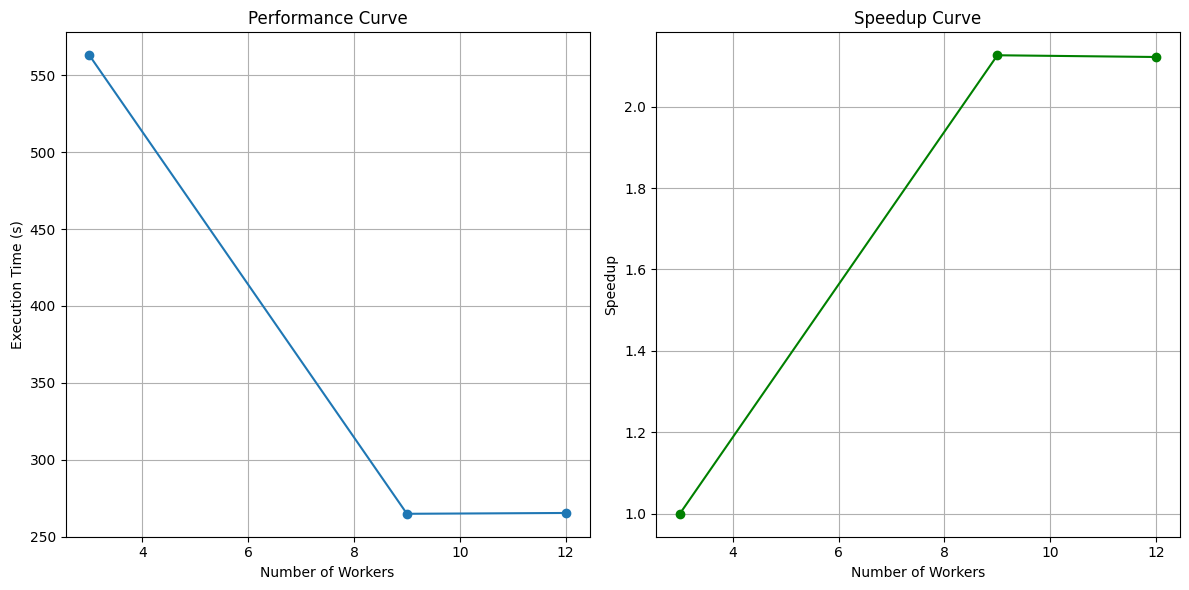

In [10]:
import matplotlib.pyplot as plt

# Replace this with your actual execution times

number_of_workers = [3, 9, 12]

# Calculating speedup
base_time = times[0]  # Time taken for execution with 1 worker
speedup = [base_time / t for t in times]

# Plotting performance curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(number_of_workers, times, marker='o')
plt.title('Performance Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (s)')
plt.grid(True)

# Plotting speedup curve
plt.subplot(1, 2, 2)
plt.plot(number_of_workers, speedup, marker='o', color='green')
plt.title('Speedup Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()